In [23]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import pandas as pd
import time
import os
import copy

plt.ion()   # interactive mode

In [24]:
# Unpack val folder
val_labels, val_path = [], "tiny-imagenet-5/val"

with open(file=os.path.join(val_path, 'val_annotations.txt')) as f:
    val_labels = f.readlines()

val_labels = [tuple(item.strip("\n").split("\t")[:2]) for item in val_labels]

# item[0] is imagePath and item[1] is class folder
for item in val_labels:
    img_path = os.path.join(val_path, "images", item[0])
    if not os.path.isdir(os.path.join(val_path, item[1])):
        os.mkdir(os.path.join(val_path, item[1]))
        
    os.popen('cp {} {}'.format(img_path, os.path.join(val_path, item[1], item[0])))    

In [15]:
import shutil
shutil.rmtree(os.path.join(val_path, "images"))

In [25]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'tiny-imagenet-5'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

In [26]:
image_datasets['val'].classes = image_datasets['train'].classes
print(image_datasets['train'].classes)
print(image_datasets['val'].classes)

['n09193705', 'n09246464', 'n09256479', 'n09332890', 'n09428293']
['n09193705', 'n09246464', 'n09256479', 'n09332890', 'n09428293']


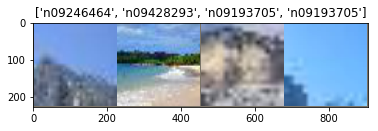

In [27]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [28]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [29]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

In [30]:
# Load pre-trained model and reset final fully connected layer

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [31]:
# Train Model
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


RuntimeError: Assertion `cur_target >= 0 && cur_target < n_classes' failed.  at /Users/soumith/code/builder/wheel/pytorch-src/torch/lib/THNN/generic/ClassNLLCriterion.c:87

# Reformat Val Data Label

In [68]:
# Create label mapping for each class
labelDict = {}
for i, label in enumerate(image_datasets['train'].classes):
    labelDict[label] = i
print(labelDict)

{'n09246464': 1, 'n09256479': 2, 'n09332890': 3, 'n09193705': 0, 'n09428293': 4}


In [77]:
# Load val annotations
valDir = 'tiny-imagenet-5/val/val_annotations.txt'
valData = pd.read_csv(valDir, sep="\t", header=None)
valAnno = valData.iloc[:,:2]

In [141]:
labelList = np.zeros(len(valAnno))
for i in range(0, len(valAnno)):
    imageName, imageClass = valAnno.iloc[i,0], valAnno.iloc[i,1]
    label = labelDict[imageClass]
    labelList[i] = int(label)

In [166]:
for i, imageDataTuple in enumerate(image_datasets['val'].imgs):
    imageData = np.array(imageDataTuple)
    imageData[1] = int(labelList[i])
    image_datasets['val'].imgs[i] = tuple(imageData)